In [485]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
#from prophet import Prophet

In [486]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [487]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [488]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [489]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [490]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [491]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [505]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
#model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)
model_fitted = model.fit(9, method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())
#model_fitted.k_ar

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Mar, 2025
Time:                     15:25:35
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    3.77118
Nobs:                     196.000    HQIC:                  -5.18739
Log likelihood:          -775.543    FPE:                2.64690e-05
AIC:                     -11.2814    Det(Omega_mle):     6.04837e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -1.336910         0.511819           -2.612           0.009
L1.Hoyre          -1.272146         0.518812           -2.452           0.014
L1.Frp            -1.457460         0.520254           -2.801           0.0

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [493]:
steps = 8  # Number of steps to forecast
alpha = 0.5

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-02-28", periods=steps, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


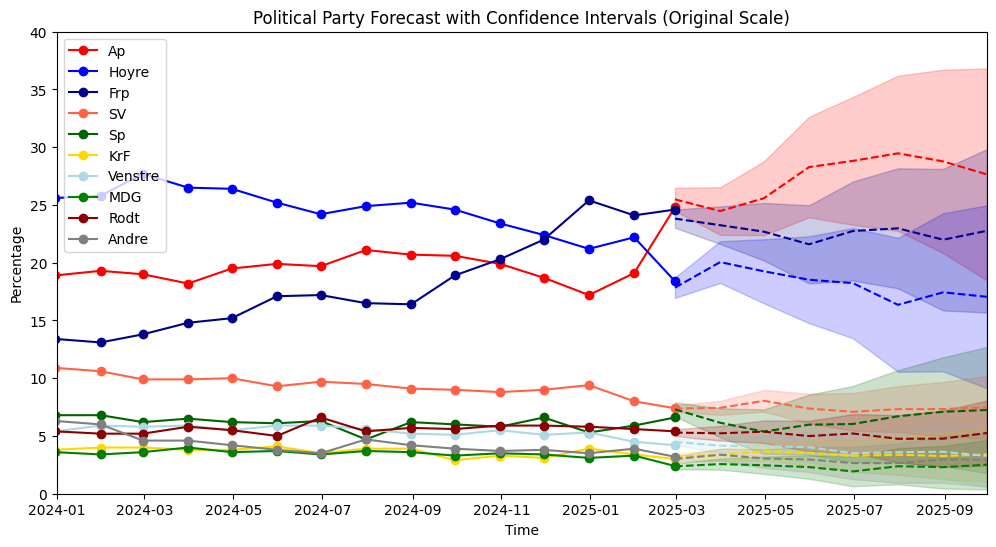

In [494]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)

plt.xlim(np.datetime64("2024-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast with Confidence Intervals (Original Scale)")
plt.legend(loc="upper left")
plt.show()

In [495]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,25.486870,17.840937,23.818638,7.377251,7.305262,3.223735,4.492279,2.369363,5.293044,3.008877
2025-03-31,24.472187,20.053923,23.249417,7.433958,6.143939,3.360462,4.160200,2.566491,5.230786,3.375148
2025-04-30,25.584293,19.257214,22.688209,8.040892,5.381065,3.673488,4.125568,2.463977,5.374649,3.051533
2025-05-31,28.281375,18.526158,21.594842,7.374744,5.976619,3.545323,4.020551,2.306186,4.991994,2.965305
2025-06-30,28.815933,18.235304,22.743655,7.091408,6.035274,3.286675,3.508338,1.931550,5.215245,2.652603
2025-07-31,29.470727,16.354722,22.977671,7.323128,6.704698,3.381495,3.593832,2.380852,4.754418,2.649636
2025-08-31,28.771416,17.438353,21.991732,7.325607,7.095686,3.261430,3.629573,2.298464,4.768855,2.965673
2025-09-30,27.646397,17.048341,22.763416,7.479987,7.247072,3.397470,3.272810,2.509857,5.255092,2.940843


In [496]:
forecast_lower_original_scale


,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,24.487825,16.954164,23.024665,7.089467,6.690411,2.993211,4.212245,2.131125,4.995410,2.760936
2025-03-31,22.408337,18.246635,21.622010,6.827134,4.887552,2.856550,3.556552,2.080143,4.597435,2.855865
2025-04-30,22.390331,16.483885,20.196782,7.098922,3.461088,2.886870,3.191380,1.716651,4.397776,2.252104
2025-05-31,23.928707,14.765567,18.213061,6.093430,3.378151,2.459074,2.750511,1.290983,3.669054,1.872067
2025-06-30,23.284986,13.465950,18.457523,5.460041,2.742809,1.895418,1.896353,0.643792,3.535242,1.259061
2025-07-31,22.751113,10.557559,17.779366,5.332221,2.705925,1.678980,1.631609,0.814649,2.704009,0.950479
2025-08-31,20.832090,10.592779,15.864568,4.972666,2.380746,1.242583,1.307637,0.449633,2.336995,0.950454
2025-09-30,18.474514,9.128800,15.690453,4.758446,1.789688,1.054284,0.585644,0.371533,2.437997,0.604517


In [497]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,26.485915,18.727711,24.612612,7.665036,7.920114,3.454259,4.772314,2.607602,5.590678,3.256819
2025-03-31,26.536036,21.861210,24.876825,8.040783,7.400325,3.864374,4.763848,3.052839,5.864137,3.894431
2025-04-30,28.778255,22.030542,25.179636,8.982863,7.301042,4.460106,5.059757,3.211303,6.351521,3.850961
2025-05-31,32.634043,22.286748,24.976622,8.656057,8.575087,4.631572,5.290591,3.321389,6.314934,4.058543
2025-06-30,34.346879,23.004659,27.029788,8.722774,9.327739,4.677932,5.120322,3.219309,6.895248,4.046144
2025-07-31,36.190341,22.151886,28.175977,9.314036,10.703470,5.084010,5.556055,3.947056,6.804827,4.348793
2025-08-31,36.710742,24.283926,28.118895,9.678549,11.810626,5.280276,5.951510,4.147294,7.200714,4.980893
2025-09-30,36.818281,24.967882,29.836379,10.201527,12.704455,5.740656,5.959975,4.648182,8.072186,5.277169


In [498]:
# Example: Your existing dataframes (assuming they have the same index and columns)
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  27.646397  18.474514  36.818281
1    Hoyre  17.048341   9.128800  24.967882
2      Frp  22.763416  15.690453  29.836379
3       SV   7.479987   4.758446  10.201527
4       Sp   7.247072   1.789688  12.704455
5      KrF   3.397470   1.054284   5.740656
6  Venstre   3.272810   0.585644   5.959975
7      MDG   2.509857   0.371533   4.648182
8     Rodt   5.255092   2.437997   8.072186
9    Andre   2.940843   0.604517   5.277169


In [499]:
# Antall simuleringar
n_sim = 10000

# Trekke stemmer frå normalfordeling
red_green_votes = np.zeros(n_sim)
blue_votes = np.zeros(n_sim)

# Iterate over the result_df DataFrame
for _, row in result_df.iterrows():
    party = row["Party"]
    yhat = row["Estimate"]
    lower = row["Lower"]
    upper = row["Upper"]

    z_alpha_half = norm.ppf(1 - (1 - alpha) / 2)  # Compute Z-score for given alpha
    factor = 2 * z_alpha_half  # Convert to full interval width
    #print(factor)
    std_dev = (upper - lower) / factor  # Omformar intervall til standardavvik (~50% dekking)
    samples = np.random.normal(yhat, std_dev, n_sim)
    
    if party in ["Ap", "SV", "Sp", "Rodt", "MDG"]:
        red_green_votes += samples
    else:
        blue_votes += samples

# Sannsyn for at den raudgrøne blokka er større
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.5053
